# <h1><center>Sim-to-Real with **rex** (Robotic Environments with jaX)  <a href="https://colab.research.google.com/"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

This notebook offers an introductory tutorial for **rex (Robotic Environments with jaX)**, a **JAX-based framework** for building **graph-based environments** designed for **sim2real robotics**.

In this tutorial, we will walk through a **simple sim-to-real example** using rex, where we will:
1. Define a **simple pendulum system** as an interconnected set of nodes, where:
   - **brax** is used as a stand-in for the **real-world system**.
   - We simulate **real-world asynchronous effects** by introducing **communication and computation delays** using predefined delay distributions.
   - The **node definitions** used in this notebook are covered in detail in the **node_definitions.ipynb** notebook.
2. Apply **open-loop control** to the pendulum system to gather data.
3. Use the collected data to:
   - Fit **Gaussian Mixture Models (GMM)** to estimate the delays introduced in step (1).
   - Build an **ODE simulation environment**.
   - Use **evolutionary strategies** to identify hidden delays and parameters in the ODE environment that best match the collected data.
4. Train an agent to balance the pendulum in the ODE environment using **PPO (Proximal Policy Optimization)**.
5. **Zero-shot transfer** the trained agent to the **real-world environment**.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".

In [2]:
# @title Install Necessary Libraries
# @markdown This cell installs the required libraries for the project.
# @markdown If you are running this notebook in Google Colab, most libraries should already be installed.


import os
import multiprocessing
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    max(multiprocessing.cpu_count(), 1)
)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

try:
    import rex
    print("Rex already installed")
except ImportError as e:
    print("Installing rex via `pip install rex-lib[examples]`. "
          "If you are running this in a Colab notebook, you can ignore this message.")
    !pip install rex-lib[examples]

Rex already installed


In [3]:
# @title Import Libraries & Check GPU Availability
# @markdown We import all necessary libraries here, including JAX, numpy, and others.
# @markdown Additionally, we check if a GPU is available and display the number of CPU cores.

from IPython.display import HTML
import functools
import jax
import itertools
import tqdm
import jax.numpy as jnp
import equinox as eqx
import numpy as onp
from distrax import Deterministic, Normal
import supergraph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import rex.utils as rutils
import rex.base as base
from rex.open_colors import ecolor, fcolor
from rex.constants import RealTimeFactor, Clock
from rex.base import TrainableDist

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
    gpu = gpu[0] if len(gpu) > 0 else None
    print("GPU found!")
except RuntimeError:
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")
    gpu = None

# Check the number of available CPU cores
print(f"CPU cores available: {len(jax.devices('cpu'))}")
cpus = itertools.cycle(jax.devices("cpu"))

GPU found!
CPU cores available: 2


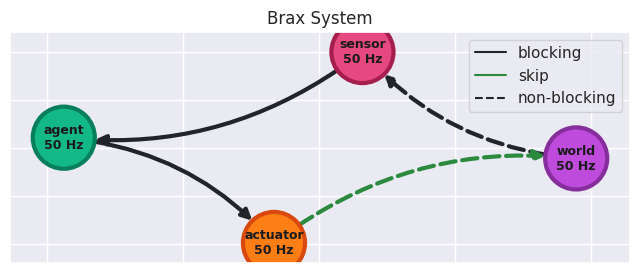

In [4]:
# @title Define Pendulum System as an Interconnection of Nodes
# @markdown We will use nodes defined in the pendulum example to simulate the system.
# @markdown Since we do not have access to a real-world pendulum, the Brax simulation will act as our "real-world" system.
# @markdown Data from Brax will help us identify the delays and parameters of a simple ODE model.
# @markdown In a separate notebook, we demonstrate how to define nodes.
# @markdown Optionally, you can test the system with zero delays by uncommenting the relevant code.
from rex.pendulum.actuator import Actuator
from rex.pendulum.sensor import Sensor
from rex.pendulum.agent import Agent
from rex.pendulum.brax import BraxWorld

# `Color` and `order` arguments are merely for visualization purposes.
# Delay distributions are used to simulate the delays as if the nodes were real-world systems.
# For real-world systems, it is normally not necessary to specify the delay distributions.
sensor = Sensor(name="sensor", rate=50, color="pink", order=1,  # Sensor that reads the angle from the pendulum
                delay_dist=Normal(loc=0.0075, scale=0.003))  # Computation delay of the sensor
agent = Agent(name="agent", rate=50, color="teal", order=3,  # Agent that generates random actions
              delay_dist=Normal(loc=0.01, scale=0.003))  # Computation delay of the agent
actuator = Actuator(name="actuator", rate=50, color="orange", order=2,  # Actuator that applies the action to the pendulum
                    delay_dist=Normal(loc=0.0075, scale=0.003))  # Computation delay of the actuator
# Computation delay of the world is the world's step size (i.e. 1/rate)
world = BraxWorld(name="world", rate=50, color="grape", order=0)  # Brax world that simulates the pendulum
nodes = dict(world=world, sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes
# The window determine the buffer size, i.e., the number of previous messages that are stored and can be accessed
# in the .step() method of the node. The window should be at least 1, as the most recent message is always stored.
# Blocking connections are synchronous, i.e., the receiving node waits for the sending node to send a message.
# The window determines the number of messages that are stored and can be accessed in the .step() method of the node.
agent.connect(sensor, window=3, name="sensor", blocking=True,  # Use the last three sensor messages as input (sync communication)
              delay_dist=Normal(loc=0.002, scale=0.002))  # Communication delay of the sensor
actuator.connect(agent, window=1, name="agent", blocking=True,  # Agent receives the most recent action (sync communication)
                 delay_dist=Normal(loc=0.002, scale=0.002))  # Communication delay of the agent

# Connections below would not be necessary in a real-world system,
# but are used to communicate the action to brax, and convert brax's state to a sensor message
# Delay distributions are used to simulate the delays in the real-world system
sensor_delay, actuator_delay = 0.01, 0.01
std_delay = 0.002
world.connect(actuator, window=1, name="actuator", skip=True,  # Sends the action to the brax world (skip=True to resolve circular dependency)
              delay_dist=Normal(loc=actuator_delay, scale=std_delay))  # Actuator delay between applying the action, and the action being effective in the world
sensor.connect(world, window=1, name="world",  # Communicate brax's state to the sensor node
               delay_dist=Normal(loc=sensor_delay, scale=std_delay))  # Sensor delay between reading the state, and the world's state corresponding to the sensor reading.

# If you want to test with zero delays, uncomment below.
# sensor_delay, actuator_delay = 0.0, 0.0
# std_delay = 0.0
# for n in [sensor, agent, actuator]:
#     n.set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)
#     for i in n.inputs.values():
#         i.set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)
# world.inputs["actuator"].set_delay(delay_dist=Deterministic(loc=0.0), delay=0.0)

# Visualize the system
node_infos = {name: n.info for name, n in nodes.items()}
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
rutils.plot_system(node_infos, ax=ax, k=1)
ax.legend()
ax.set_title("Brax System");

In [5]:
# @title Apply Open-Loop Control to the Pendulum System to Gather Data
# @markdown This section collects data such as delays, actions, and sensor readings,
# @markdown by applying open-loop control to the simulated pendulum.

# Build the graph
# Note that one of the nodes is designated as the supervisor (agent).
# To make a comparison with the standard Gym-like approach, the supervisor node is the agent, and the other nodes are the environment.
# This means that the graph will be executed in a step-by-step manner, where the agent's rate determines the rate of the environment.
from rex.asynchronous import AsyncGraph
graph = AsyncGraph(nodes=nodes, supervisor=nodes["agent"],
                   # Settings for simulating at fast as possible speed according to specified delays
                   clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.FAST_AS_POSSIBLE,
                   # Settings for simulating at real-time speed according to specified delays
                   # clock=Clock.SIMULATED, real_time_factor=RealTimeFactor.REAL_TIME,
                   # Settings for real-world deployment
                   # clock=Clock.WALL_CLOCK, real_time_factor=RealTimeFactor.REAL_TIME,
                   )

# Specify what we want to record (params, state, output) for each node,
graph.set_record_settings(params=True, inputs=False, state=True, output=True)

# Get initial graph state (aggregate of all node states)
rng = jax.random.PRNGKey(1)
rng, rng_init = jax.random.split(rng)
# 'order' defines the order in which the nodes must be initialized (some node initialization procedures may depend on the result of others)
gs_init = graph.init(rng_init, order=("agent",))
gs_init_real = gs_init  # Used later for evaluating the trained model from the same initial state

# Ahead-of-time compilation of the step method of each node
# Place all nodes on the CPU, except the agent, which is placed on the GPU (if available)
devices_step = {k: next(cpus) if k != "agent" or gpu is None else gpu for k in nodes}
graph.warmup(gs_init, devices_step, jit_step=True, profile=True)  # Profile=True for profiling the step function

# Prepare open-loop action sequence
rng, rng_actions = jax.random.split(rng)
dt_action = 2.0
num_actions = 6
actions = jnp.array([-1.7, 1.7, -1, 1, 0., 0.1])[:, None]
actions = jnp.repeat(actions, int(jnp.ceil(dt_action * nodes["agent"].rate)), axis=0)  # Repeat actions for the duration of the agent's rate
num_steps = actions.shape[0]

# Execution: Gym-like API with .reset() & .step() methods
# We use the the graph state obtained with .init() and perform step-by-step.
gs, ss = graph.reset(gs_init)  # Reset the graph to the initial state (returns the gs and the step state of the agent)
for i in tqdm.tqdm(range(num_steps), desc="brax | gather data"):
    # Access the last sensor message of the input buffer
    # -1 is the most recent message, -2 the second most recent, etc. up until the window size
    sensor_msg = ss.inputs["sensor"][-1].data # .data grabs the pytree message object
    action = actions[i]  # Get the action for the current time step
    output = ss.params.to_output(action)  # Convert the action to an output message
    # Step the graph (i.e., executes the next time step by sending the output message to the actuator node)
    gs, ss = graph.step(gs, ss, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background

# Get the episode data (params, delays, outputs, etc.)
record = graph.get_record()  # Gets the records of all nodes

# Filter out the world node, as it would not be available in a real-world system
rollout_real = record.nodes["world"].steps.state
nodes_real = {name: n for name, n in nodes.items() if name != "world"}
record = record.filter(nodes_real)

[2273 ][MainThread               ][tracer              ][world.step | pre-compile ] Elapsed: 1.7329 sec
[2273 ][MainThread               ][tracer              ][world.step | time-profile] Elapsed: 0.0013 sec (x10 repeats = 0.0132 sec)
[2273 ][MainThread               ][tracer              ][sensor.step | pre-compile ] Elapsed: 0.0382 sec
[2273 ][MainThread               ][tracer              ][sensor.step | time-profile] Elapsed: 0.0011 sec (x10 repeats = 0.0114 sec)
[2273 ][MainThread               ][tracer              ][agent.step | pre-compile ] Elapsed: 0.5580 sec
[2273 ][MainThread               ][tracer              ][agent.step | time-profile] Elapsed: 0.0008 sec (x10 repeats = 0.0080 sec)
[2273 ][MainThread               ][tracer              ][actuator.step | pre-compile ] Elapsed: 0.0252 sec
[2273 ][MainThread               ][tracer              ][actuator.step | time-profile] Elapsed: 0.0006 sec (x10 repeats = 0.0062 sec)


brax | gather data: 100%|██████████| 600/600 [00:07<00:00, 76.00it/s]


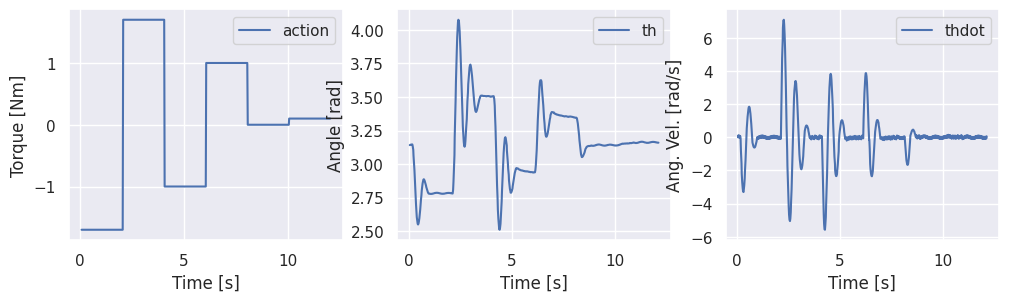

In [6]:
# @title Visualize Actions and Sensor Readings
# @markdown The plots below display the actions and sensor readings as might be observed in a real-world system.

fig_data, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(record.nodes["agent"].steps.ts_end[:-1], record.nodes["agent"].steps.output.action, label="action")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.th, label="th")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.thdot, label="thdot")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [7]:
# @title Fit GMM to Communication and Computation Delays
# @markdown We will fit a Gaussian Mixture Model (GMM) to the delays observed in the communication between the sensor and agent,
# @markdown as well as the computation delay of the agent’s step method.
# @markdown Other delays, such as actuator delays, can be fitted similarly.

from rex.gmm_estimator import GMMEstimator

# Fit GMM to communication delay between sensor and agent
delay_comm = record.nodes["agent"].inputs["sensor"].messages.delay
gmm_comm = GMMEstimator(delay_comm, "communication_delay")
gmm_comm.fit(num_steps=100, num_components=2, step_size=0.05, seed=0)
dist_comm = gmm_comm.get_dist()

# Fit GMM to computation delay of the agent's step method
delay_comp = record.nodes["agent"].steps.delay
gmm_comp = GMMEstimator(delay_comp, "computation_delay")
gmm_comp.fit(num_steps=100, num_components=2, step_size=0.05, seed=0)
dist_comp = gmm_comp.get_dist()

communication_delay | Time taken: 2.41 seconds.
computation_delay | Time taken: 3.91 seconds.


In [23]:
# @title Visualize Fitted GMM for Delays
# @markdown This cell plots the GMM fitting process to the delays for both the sensor-agent communication and the agent's computation.

%matplotlib agg

# Plot GMMs
# with plt.ioff():
fig_gmm, axes = plt.subplots(1, 2, figsize=(8, 3));
gmm_comm.plot_hist(ax=axes[0], edgecolor=ecolor.communication, facecolor=fcolor.communication, plot_dist=True)
axes[0].set_title("Delay (sensor->agent)")
gmm_comp.plot_hist(ax=axes[1], edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False)
axes[1].set_title("Delay (agent.step)")
for ax, dist in zip(axes, [dist_comm, dist_comp]):
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.3f'))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel('delay (s)', fontsize=10)
    ax.set_ylabel('density', fontsize=10)
    ax.set_xlim([0, dist.quantile(0.99)])  # Limit the x-axis to the 99th percentile of the delay

# Animate training
ani = gmm_comp.animate_training(fig=fig_gmm, ax=axes[1], num_frames=50)
# If you are running into an AttributeError regarding "_val_or_rc", skip the HTML display and run the next cell.
# This seems to be a Python 3.10 + matplotlib 3.9.x issue.
# Resolve by downgrading matplotlib to 3.7.x. Run `!pip install matplotlib==3.7.5`.
HTML(ani.to_html5_video())

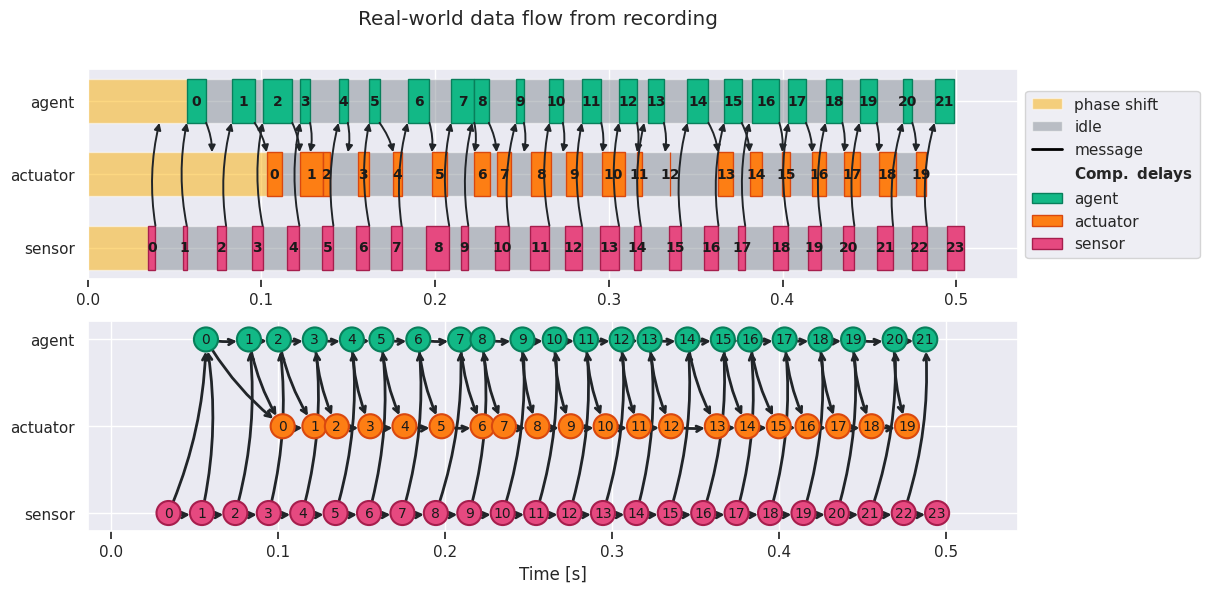

In [9]:
# @title Visualize Data Flow in the Real-World System
# @markdown The top plot shows how long each node takes to process data and forward it to the next node.
# @markdown The bottom plot provides a graph representation that will form the basis for the computational graph used for system identification.
# @markdown - Each vertex represents a step call of a node, and each edge represents message transmission between two nodes.
# @markdown - Edges between consecutive steps of the same node represent the transmission of the internal state of the node.
# @markdown - Nodes start processing after an initial phase-shift, which can be controlled in the node definition.

plt.close(fig_gmm) # Close fig_gmm to prevent it from displaying in the next cell
%matplotlib inline

df = record.to_graph()
timing_mode = "arrival"  # "arrival" or "usage"
G = rutils.to_networkx_graph(df, nodes=nodes)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
rutils.plot_graph(G, max_x=0.5, ax=axes[0], message_arrow_timing_mode=timing_mode,
                  edge_linewidth=1.4, arrowsize=10,
                  show_labels=True, height=0.6, label_loc="center")
supergraph.plot_graph(G, max_x=0.5, ax=axes[1])
fig.suptitle("Real-world data flow from recording")
axes[-1].set_xlabel("Time [s]");

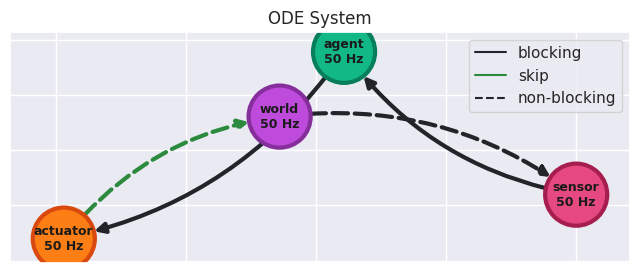

In [10]:
# @title Build an ODE Simulation Environment to Identify Hidden Delays and Parameters
# @markdown We use collected data to build and identify delays and parameters in a simple ODE model.
# @markdown This model incorporates the communication and computation delays identified for the agent.

# Prepare the recorded data that we are going to use for system identification
outputs = {name: n.steps.output[None] for name, n in record.nodes.items()}

# By reinitializing the nodes via the `from_info` method, we can reuse the exact same configuration (rate, delay_dist, etc.).
# We can overwrite (e.g., delay_dist) or specify extra parameters (e.g., outputs) as keyword arguments.
# The info data is stored in the record, but can also be obtained from the nodes themselves with node.info.
from rex.pendulum.actuator import SimActuator
from rex.pendulum.sensor import SimSensor
from rex.pendulum.agent import Agent
from rex.pendulum.ode import OdeWorld
actuator = SimActuator.from_info(record.nodes["actuator"].info, outputs=outputs["actuator"])  # Actuator data to replay the actions
sensor = SimSensor.from_info(record.nodes["sensor"].info, outputs=outputs["sensor"])  # Sensor data to calculate reconstruction error
agent = Agent.from_info(record.nodes["agent"].info, delay_dist=dist_comp)
nodes_sim = dict(sensor=sensor, agent=agent, actuator=actuator)

# Connect nodes according to real-world system
[n.connect_from_info(record.nodes[name].info.inputs, nodes_sim) for name, n in nodes_sim.items()]

# Create the world node that is going to simulate the ODE system
world = OdeWorld.from_info(nodes["world"].info)  # Initialize OdeWorld with the same parameters (rate, etc.) as the brax world

# Next, we connect the world node to the nodes that interface with hardware (actuator and sensor)
# We specify trainable delays to represent sensor and actuator delays that we want to identify in addition to the ode parameters
world.connect(actuator, window=1, name="actuator", skip=True,  # Sends the action to the ODE world (skip=True to resolve circular dependency)
              # Trainable delay to represent the actuator delay
              # delay, min, and max are seconds, interp in ["zoh", "linear"]
              delay_dist=TrainableDist.create(delay=0.0, min=0, max=0.3, interp="linear"))
sensor.connect(world, window=1, name="world",  # Communicate the ODE world's state to the sensor node
               # Trainable delay to represent the sensor delay
               # delay, min, and max are seconds, interp in ["zoh", "linear"]
               delay_dist=TrainableDist.create(delay=0.0, min=0, max=0.3, interp="linear"))
nodes_sim["world"] = world  # Add the world node to the nodes

# Visualize the system
node_infos = {name: n.info for name, n in nodes_sim.items()}
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
rutils.plot_system(node_infos, ax=ax, k=1)
ax.legend()
ax.set_title("ODE System");

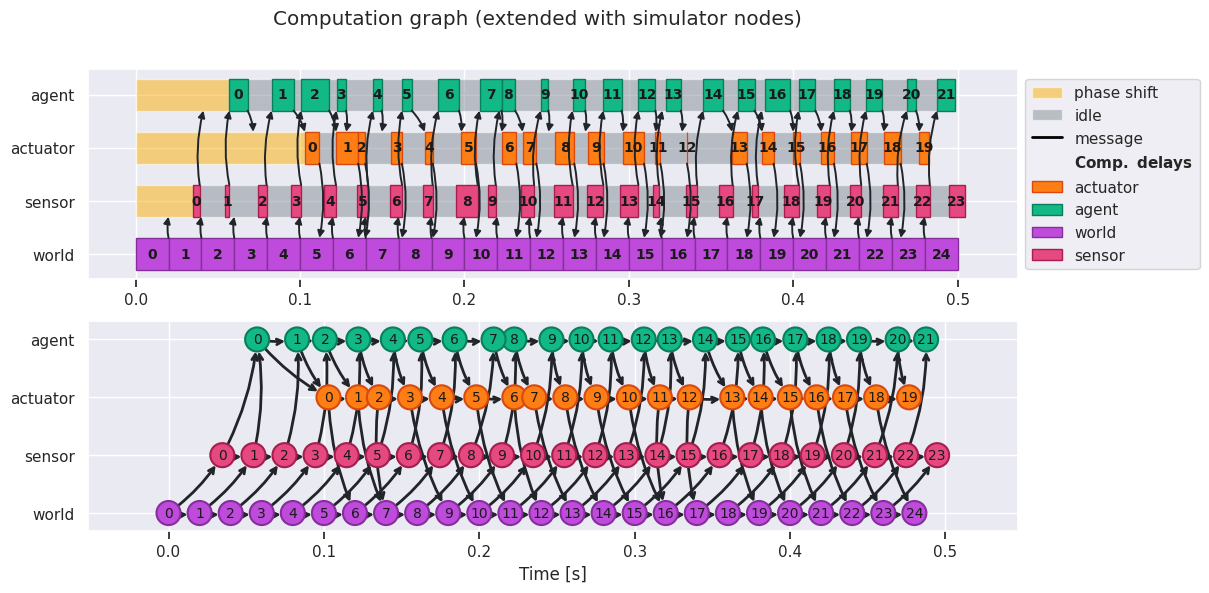

In [11]:
# @title Build Computational Graph for System Identification
# @markdown This graph includes vertices representing simulator (i.e. world) steps and edges representing sensor and actuator
# @markdown delays between the world and the sensor/actuator nodes.
# @markdown The min/max values from the trainable delay distributions are used to define these edges.

rng, rng_aug = jax.random.split(rng)
cg = rex.artificial.augment_graphs(df, nodes_sim, rng_aug)
timing_mode = "arrival"  # "arrival" or "usage"
G = rutils.to_networkx_graph(cg, nodes=nodes)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
rutils.plot_graph(G, max_x=0.5, ax=axes[0], message_arrow_timing_mode=timing_mode,
                  edge_linewidth=1.4, arrowsize=10,
                  show_labels=True, height=0.6, label_loc="center")
supergraph.plot_graph(G, max_x=0.5, ax=axes[1])
fig.suptitle(f"Computation graph (extended with simulator nodes)")
axes[-1].set_xlabel("Time [s]");

In [12]:
# @title Define Subset of Trainable Parameters (Delays and ODE Parameters)
# @markdown The following loop describes the training process for identifying hidden delays and system parameters:
# @markdown 1. Sample normalized parameters from a search distribution.
# @markdown 2. Denormalize based on parameter min/max values.
# @markdown 3. Extend trainable parameters with non-trainable ones.
# @markdown 4. Run simulation and collect reconstruction errors.
# @markdown 5. Update search distribution based on the error.
# @markdown 6. Repeat until convergence.

# Initialize a graph that can be compiled and parallelized for system identification
# Note, we could choose to skip running the agent node for computational efficiency,
# as we know it does not affect the world node in this case, as we are replaying the actions in the actuator node.
graph_sim = rex.graph.Graph(nodes_sim, nodes_sim["agent"], cg)

# Get initial graph state (aggregate of all node states)
rng, rng_init = jax.random.split(rng)
gs_init = graph_sim.init(rng_init, order=("agent",))
gs_init_sim = gs_init

# Define the set of trainable parameters and the initial values
# We only want to optimize for a subset of the parameters, e.g., the delays and the parameters of the ODE system.
# Hence, we take all parameters, set them them to None (i.e., not trainable),
# and then set the ones we want to optimize to trainable values.
base_params = gs_init.params.unfreeze().copy()  # Get base structure for params
init_params = jax.tree_util.tree_map(lambda x: None, base_params)  # Set all parameters to None (i.e. not trainable)
init_params["world"] = init_params["world"].replace(J=0.0001,   # Inertia of the pendulum (trainable)
                                                    mass=0.05,  # Mass of the pendulum (trainable)
                                                    length=0.03,  # Length of the pendulum (trainable)
                                                    b=1.e-05,   # Damping of the pendulum (trainable)
                                                    K=0.02,     # Spring constant of the pendulum (trainable)
                                                    R=5.,          # DC-motor resistance of the pendulum (trainable)
                                                    c=0.0007)    # Coulomb friction of the pendulum (trainable)
init_params["sensor"] = init_params["sensor"].replace(sensor_delay=0.15)  # Sensor delay (trainable)
init_params["actuator"] = init_params["actuator"].replace(actuator_delay=0.15)  # actuator delay (trainable)
init_params["agent"] = init_params["agent"].replace(init_method="parametrized",  # Set to "parametrized" avoid random state initialization
                                                    parametrized=jnp.array([0.5*jnp.pi, 0.0])) # Initial state (trainable)

# Print the initial parameters
print("Initial parameters (None means not trainable, some are static):")
eqx.tree_pprint(init_params, short_arrays=False)

# It's also good practice to perform a search over normalized parameters, provided we are given a min and max for each parameter.
min_params, max_params = init_params.copy(), init_params.copy()  # Get base structure for min and max params
# Set the min and max for the ODE parameters
min_params["world"] = jax.tree_util.tree_map(lambda x: x*0.25, min_params["world"])  # Set the min for the ODE parameters
max_params["world"] = jax.tree_util.tree_map(lambda x: x*2.0, max_params["world"])  # Set the max for the ODE parameters
# Set the min and max for the delays
min_params["sensor"] = min_params["sensor"].replace(sensor_delay=0.0)  # Set the min for the sensor delay
max_params["sensor"] = max_params["sensor"].replace(sensor_delay=0.3)  # Set the max for the sensor delay
min_params["actuator"] = min_params["actuator"].replace(actuator_delay=0.0)  # Set the min for the actuator delay
max_params["actuator"] = max_params["actuator"].replace(actuator_delay=0.3)  # Set the max for the actuator delay
# Ensure agent's initial state has a non-zero range, as 0.5*0 = 0, and 1.5*0 = 0
# if max_params["agent"].parametrized is not None:  # todo: remove
min_params = eqx.tree_at(lambda _min: _min["agent"].parametrized, min_params, jnp.array([-jnp.pi, -0.2]))  # Set the min for the initial state
max_params = eqx.tree_at(lambda _max: _max["agent"].parametrized, max_params, jnp.array([jnp.pi, 0.2]))  # Set the max for the initial state

# Next, we define the transform that transforms the normalized candidate parameters to the full parameter structure
# First, we denormalize the parameters, then extend with the non-trainable parameters (e.g., max_speed of the ODE world)
denorm = base.Denormalize.init(min_params, max_params)  # Create a transform to denormalize a set of normalized parameters
extend = base.Extend.init(base_params, init_params)  # Create a transform to extend the trainable params with the non-trainable
denorm_extend = base.Chain.init(denorm, extend)

# Normalize the initial, min, and max parameters
norm_init_params = denorm.inv(init_params)  # Normalize the initial parameters
norm_min_params = denorm.inv(min_params)  # Normalize the min parameters
norm_max_params = denorm.inv(max_params)  # Normalize the max parameters

Growing supergraph: 100%|██████████| 601/601 [00:01<00:00, 401.62it/s, 1/1 graphs, 2411/2411 matched (66.86% efficiency, 6 nodes (pre-filtered: 6 nodes))]


Initial parameters (None means not trainable, some are static):
{
  'actuator':
  ActuatorParams(actuator_delay=0.15),
  'agent':
  AgentParams(
    policy=None,
    num_act=4,
    num_obs=4,
    max_torque=None,
    init_method='parametrized',
    parametrized=Array([1.5707964, 0.       ], dtype=float32),
    max_th=None,
    max_thdot=None,
    gamma=None,
    tmax=None
  ),
  'sensor':
  SensorParams(sensor_delay=0.15),
  'world':
  OdeParams(
    max_speed=None,
    J=0.0001,
    mass=0.05,
    length=0.03,
    b=1e-05,
    K=0.02,
    R=5.0,
    c=0.0007,
    dt_substeps_min=0.01,
    dt=0.02
  )
}


In [13]:
# @title Define Loss Function for Identifying Delays and Parameters
# @markdown This function calculates the reconstruction error for a given set of normalized parameters.
# @markdown The error is used to guide optimization during the training process.

def get_loss(norm_params, transform, rng):
    # Transform normalized parameters to full parameter structure
    params = transform.apply(norm_params)  # := denorm_extend.apply(norm_params)

    # Initialize the graph state
    # By supplying the params, we override the params generated by every node's init_params method
    # This allows us to run the graph with the specified parameters
    gs_init = graph_sim.init(rng=rng, params=params, order=("agent",))

    # Rollout graph
    final_gs = graph_sim.rollout(gs_init, carry_only=True)

    # Get the reconstruction error
    loss_th = final_gs.state["sensor"].loss_th
    loss_thdot = final_gs.state["sensor"].loss_thdot
    loss = loss_th + loss_thdot
    return loss

# Get cost of initial guess
init_loss = get_loss(norm_init_params, denorm_extend, rng)  # Get the initial loss
print(f"Loss of initial guess: {init_loss}")  # Loss using the initial parameters

Loss of initial guess: 11958.76171875


In [14]:
# @title Initialize CMA-ES Solver for System Identification
# @markdown We will use the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) to optimize parameters.
# @markdown The solver is initialized with the normalized parameter bounds (min and max).

import rex.evo as evo

# Initialize the solver
max_steps = 50  # Number of optimization steps
strategy_kwargs = dict(popsize=200, elite_ratio=0.1, sigma_init=0.4, mean_decay=0.)
solver = evo.EvoSolver.init(norm_min_params, norm_max_params, strategy="CMA_ES", strategy_kwargs=strategy_kwargs)
init_sol_state = solver.init_state(norm_init_params)  # Initialize the solver state

# Run the optimization
rng, rng_sol = jax.random.split(rng)
init_log_state = solver.init_logger(num_generations=max_steps)
with rutils.timer("evo | compile + optimize"):
    sol_state, log_state, losses = evo.evo(get_loss, solver, init_sol_state, denorm_extend, max_steps=max_steps, rng=rng_sol, verbose=True, logger=init_log_state)
norm_opt_params = solver.unflatten(sol_state.best_member)
opt_params = denorm_extend.apply(norm_opt_params)

# Print identified delays vs true delays
# Note that it's inherently not possible to distinguish between sensor and actuator delays, but we can estimate their sum.
# Hence, we compare the sum of the identified delays with the sum of the true delays.
# print(f"Sensor delay | true={sensor_delay:.3f}\u00B1{std_delay:.3f}, opt={opt_params['sensor'].sensor_delay:.3f}, init={init_params['sensor'].sensor_delay:.3f}")
# print(f"Actuator delay | true={actuator_delay:.3f}\u00B1{std_delay:.3f}, opt={opt_params['actuator'].actuator_delay:.3f}, init={init_params['actuator'].actuator_delay:.3f}")
print(f"Actuator+senor delay | "
      f"true={sensor_delay+actuator_delay:.3f}\u00B1{std_delay * 2:.3f}, "
      f"opt={opt_params['sensor'].sensor_delay+opt_params['actuator'].actuator_delay:.3f}, "
      f"init={init_params['sensor'].sensor_delay+init_params['actuator'].actuator_delay:.3f}")

def rollout(params, rng, carry_only: bool = True):
    # Initialize the graph state
    # By supplying the params, we override the params generated by every node's init_params method
    # This allows us to run the graph with the specified parameters
    gs_init = graph_sim.init(rng=rng, params=params, order=("agent",))

    # Rollout graph
    gs_rollout = graph_sim.rollout(gs_init, carry_only=carry_only)
    return gs_rollout

rng, rng_rollout = jax.random.split(rng)
init_rollout = rollout(extend.apply(init_params), rng_rollout, carry_only=False)
opt_rollout = rollout(opt_params, rng_rollout, carry_only=False)

ParameterReshaper: 11 parameters detected for optimization.
ParameterReshaper: 11 parameters detected for optimization.
step: 0 | min_loss: 1128.507568359375 | mean_loss: 107522.375 | max_loss: 568764.1875 | bestsofar_loss: 1128.507568359375 | total_samples: 200
step: 1 | min_loss: 1224.181640625 | mean_loss: 78047.7890625 | max_loss: 522426.65625 | bestsofar_loss: 1128.507568359375 | total_samples: 400
step: 2 | min_loss: 527.2860107421875 | mean_loss: 39593.453125 | max_loss: 573070.4375 | bestsofar_loss: 527.2860107421875 | total_samples: 600
step: 3 | min_loss: 323.6319274902344 | mean_loss: 24559.94921875 | max_loss: 530132.6875 | bestsofar_loss: 323.6319274902344 | total_samples: 800
step: 4 | min_loss: 502.45458984375 | mean_loss: 17058.279296875 | max_loss: 394890.28125 | bestsofar_loss: 323.6319274902344 | total_samples: 1000
step: 5 | min_loss: 97.7467041015625 | mean_loss: 19048.24609375 | max_loss: 404406.03125 | bestsofar_loss: 97.7467041015625 | total_samples: 1200
step: 

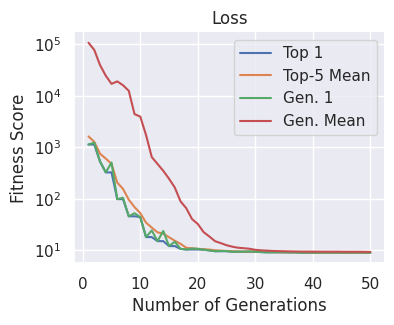

In [15]:
# @title Plot Optimization Loss
# @markdown This plot shows the loss during the parameter optimization process.
# @markdown Lower losses indicate better fit between the model and collected data.

fig_loss, ax_loss = plt.subplots(1, 1, figsize=(4, 3))
log_state.plot("Loss", fig=fig_loss, ax=ax_loss)
ax_loss.set_yscale("log");

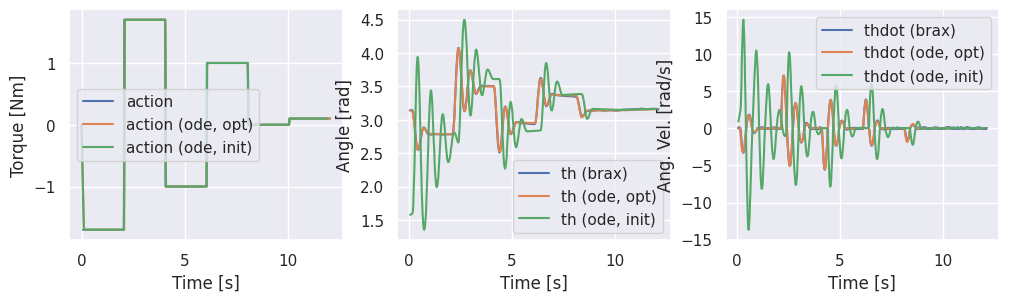

In [16]:
# @title Visualize Reconstructed and True Sensor Readings
# @markdown The following plots show the comparison between the true sensor readings and the reconstructed readings.
# @markdown A close match with both the observe and optimized lines on top of each other suggests the model is accurately capturing the system behavior.

# Rollout the optimized parameters
init_sensor = init_rollout.inputs["agent"]["sensor"].data[:, -1]
init_ts_sensor = init_rollout.inputs["agent"]["sensor"].ts_sent[:, -1]
init_actuator = init_rollout.inputs["world"]["actuator"].data[:, -1]
init_ts_actuator = init_rollout.inputs["world"]["actuator"].ts_sent[:, -1]

opt_sensor = opt_rollout.inputs["agent"]["sensor"].data[:, -1]
opt_ts_sensor = opt_rollout.inputs["agent"]["sensor"].ts_sent[:, -1]
opt_actuator = opt_rollout.inputs["world"]["actuator"].data[:, -1]
opt_ts_actuator = opt_rollout.inputs["world"]["actuator"].ts_sent[:, -1]

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(record.nodes["agent"].steps.ts_end[:-1], record.nodes["agent"].steps.output.action, label="action")
axes[0].plot(opt_ts_actuator, opt_actuator.action[:, 0], label="action (ode, opt)")
axes[0].plot(init_ts_actuator, init_actuator.action[:, 0], label="action (ode, init)")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.th, label="th (brax)")
axes[1].plot(opt_ts_sensor, opt_sensor.th, label="th (ode, opt)")
axes[1].plot(init_ts_sensor, init_sensor.th, label="th (ode, init)")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(record.nodes["sensor"].steps.ts_end, record.nodes["sensor"].steps.output.thdot, label="thdot (brax)")
axes[2].plot(opt_ts_sensor, opt_sensor.thdot, label="thdot (ode, opt)")
axes[2].plot(init_ts_sensor, init_sensor.thdot, label="thdot (ode, init)")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [17]:
# @title Train a Policy to Swing-Up the Pendulum Using PPO
# @markdown We will train a policy to swing up the pendulum using Proximal Policy Optimization (PPO) on the identified system.
# @markdown The success rate is the percentage of steps where the pendulum remains upright (cos(theta) > 0.95 and |theta_dot| < 0.5).
# @markdown We train 5 policies in parallel and select the best one based on the mean return

# Reinitialize a graph with nodes (that do not replay actions and calculate reconstruction error)
infos_sim = {name: n.info for name, n in nodes_sim.items()}
nodes_rl = {name: n.from_info(infos_sim[name]) for name, n in nodes_sim.items()}
[n.connect_from_info(infos_sim[name].inputs, nodes_rl) for name, n in nodes_rl.items()]
graph_rl = rex.graph.Graph(nodes_rl, nodes_rl["agent"], cg)

# Define the environment
from rex.pendulum.rl import SwingUpEnv, sweep_pmv2r1zf
env = SwingUpEnv(graph=graph_rl)

# Set RL params
rl_params = opt_params.copy()  # Get base structure for params
rl_params["agent"] = rl_params["agent"].replace(init_method="random")
env.set_params(rl_params)

# Initialize PPO config
# sweep_pmv2r1zf is a PPO hyperparameter sweep that was found to work well for the pendulum swing-up task
config = sweep_pmv2r1zf

# Train (success rate is the percentage of steps where the pendulum remains upright)
import rex.ppo as ppo
rng, rng_train = jax.random.split(rng)
rngs_train = jax.random.split(rng_train, num=5)  # Train 5 policies in parallel
train = functools.partial(ppo.train, env)
with rutils.timer("ppo | compile"):
    train_v = jax.vmap(train, in_axes=(None, 0))
    train_vjit = jax.jit(train_v)
    train_vjit = train_vjit.lower(config, rngs_train).compile()
with rutils.timer("ppo | train"):
    res = train_vjit(config, rngs_train)

# Get best policy (based on res.metrics["eval/mean_returns"])
best_idx = jnp.argmax(res.metrics["eval/mean_returns"][:, -1])
best_policy = res.policy[best_idx]
eval_params = rl_params.copy()
eval_params["agent"] = eval_params["agent"].replace(init_method="random", policy=best_policy)

Growing supergraph: 100%|██████████| 601/601 [00:01<00:00, 404.36it/s, 1/1 graphs, 2411/2411 matched (66.86% efficiency, 6 nodes (pre-filtered: 6 nodes))]


[2273 ][MainThread               ][tracer              ][ppo | compile       ] Elapsed: 48.3638 sec
train_steps=249856 | eval_eps=20 | return=-985.2+-133.8 | length=147+-0.0 | approxkl=0.0036 | success_rate=0.00
train_steps=249856 | eval_eps=20 | return=-483.6+-54.8 | length=147+-0.0 | approxkl=0.0035 | success_rate=0.01
train_steps=249856 | eval_eps=20 | return=-405.0+-68.0 | length=147+-0.0 | approxkl=0.0035 | success_rate=0.03
train_steps=249856 | eval_eps=20 | return=-356.4+-84.4 | length=147+-0.0 | approxkl=0.0034 | success_rate=0.06
train_steps=249856 | eval_eps=20 | return=-813.9+-86.1 | length=147+-0.0 | approxkl=0.0030 | success_rate=0.02
train_steps=499712 | eval_eps=20 | return=-919.7+-95.2 | length=147+-0.0 | approxkl=0.0029 | success_rate=0.00
train_steps=499712 | eval_eps=20 | return=-432.1+-94.4 | length=147+-0.0 | approxkl=0.0032 | success_rate=0.02
train_steps=499712 | eval_eps=20 | return=-369.6+-69.1 | length=147+-0.0 | approxkl=0.0031 | success_rate=0.05
train_steps

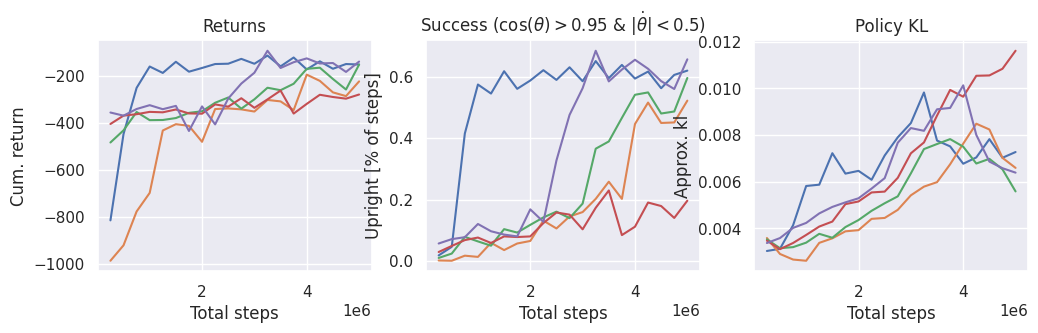

In [18]:
# @title Visualize PPO Training Progress
# @markdown The plots below show the training progress of the PPO algorithm in terms of returns, success rate, and policy KL divergence.

fig_ppo, axes_ppo = plt.subplots(1, 3, figsize=(12, 3))
total_steps = res.metrics["train/total_steps"].transpose()
mean, std = res.metrics["eval/mean_returns"].transpose(), res.metrics["eval/std_returns"].transpose()
axes_ppo[0].plot(total_steps, mean, label="mean")
axes_ppo[0].set_title("Returns")
axes_ppo[0].set_xlabel("Total steps")
axes_ppo[0].set_ylabel("Cum. return")
mean = res.metrics["eval/success_rate"].transpose()
axes_ppo[1].plot(total_steps, mean, label="mean")
axes_ppo[1].set_title(r"Success ($\cos(\theta) > 0.95$ & $|\dot{\theta}| < 0.5$)")
axes_ppo[1].set_xlabel("Total steps")
axes_ppo[1].set_ylabel("Upright [% of steps]")
mean, std = res.metrics["train/mean_approxkl"].transpose(), res.metrics["train/std_approxkl"].transpose()
axes_ppo[2].plot(total_steps, mean, label="mean")
axes_ppo[2].set_title("Policy KL")
axes_ppo[2].set_xlabel("Total steps")
axes_ppo[2].set_ylabel("Approx. kl");

In [19]:
# @title Evaluate the Learned Policy on the Simulated System (i.e. used during training)
# @markdown We evaluate the learned policy by running multiple rollouts in parallel.
# @markdown The success rate is calculated as the percentage of time the pendulum remains upright and still.

num_rollouts = 20_000  # Lower if memory is an issue
max_steps = int(5*nodes_sim["agent"].rate)  # 5 seconds

# Check if we have a GPU
try:
    gpu = jax.devices("gpu")
except RuntimeError:
    num_rollouts = 100  # Lower if no GPU is available
    print("Warning: No GPU found, falling back to CPU. Speedups will be less pronounced. Lowering the number of rollouts to 100.")
    print("Hint: if you are using Google Colab, try to change the runtime to GPU: "
          "Runtime -> Change runtime type -> Hardware accelerator -> GPU.")

def rollout_fn(rng):
    # Initialize graph state
    _gs = graph_rl.init(rng, params=eval_params, order=("agent",))
    # Make sure to record the params, state, and output
    _gs = graph_rl.init_record(_gs, params=False, state=True, output=False)
    # Run the graph for a fixed number of steps
    _gs_rollout = graph_rl.rollout(_gs, carry_only=True, max_steps=max_steps)
    # This returns a record that may only be partially filled.
    record = _gs_rollout.aux["record"]
    is_filled = record.nodes["world"].steps.seq >= 0  # Unfilled steps are marked with -1
    return is_filled, record.nodes["world"].steps.state

rng, rng_rollout = jax.random.split(rng)
rngs_rollout = jax.random.split(rng_rollout, num=num_rollouts)
t_jit = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | compile", log_level=100)  # Makes them available outside the context manager
with t_jit:
    rollout_fn_jv = jax.jit(jax.vmap(rollout_fn))
    rollout_fn_jv = rollout_fn_jv.lower(rngs_rollout)
    rollout_fn_jv = rollout_fn_jv.compile()
t_run = rutils.timer(f"Vectorized evaluation of {num_rollouts} rollouts | rollouts", log_level=100)
with t_run:
    is_filled, final_states = rollout_fn_jv(rngs_rollout)
    final_states.th.block_until_ready()

# Only keep the filled rollouts (we did not run the full duration of the computation graph)
final_states = final_states[is_filled]

# Calculate success rate
thr_upright = 0.95  # Cosine of the angle threshold
thr_static = 0.5  # Angular velocity threshold
cos_th = jnp.cos(final_states.th)
thdot = final_states.thdot
is_upright = cos_th > thr_upright
is_static = jnp.abs(thdot) < thr_static
is_valid = jnp.logical_and(is_upright, is_static)
success_rate = is_valid.sum() / is_valid.size
print(f"sim. eval | Success rate: {success_rate:.2f}")
print(f"sim. eval | fps: {(num_rollouts * max_steps) / t_run.duration / 1e6:.0f} Million steps/s | compile: {t_jit.duration:.2f} s | run: {t_run.duration:.2f} s")

[2273 ][MainThread               ][tracer              ][Vectorized evaluation of 20000 rollouts | compile] Elapsed: 5.4914 sec
[2273 ][MainThread               ][tracer              ][Vectorized evaluation of 20000 rollouts | rollouts] Elapsed: 0.2948 sec
sim. eval | Success rate: 0.82
sim. eval | fps: 17 Million steps/s | compile: 5.49 s | run: 0.29 s


In [20]:
# @title Evaluate the Learned Policy on the "Real" Brax System (i.e. sim2real transfer)
# @markdown We will now evaluate the learned policy on the real Brax simulation system, which we used to collect data in the beginning.

@jax.jit
def get_action(step_state: base.StepState):
    obs = eval_params["agent"].get_observation(step_state)
    action = eval_params["agent"].policy.get_action(obs)
    output = eval_params["agent"].to_output(action)  # Convert the action to an output message
    new_ss = step_state.replace(state=eval_params["agent"].update_state(step_state, action))
    return new_ss, output

# Run for one episode
gs, ss = graph.reset(gs_init_real)  # Reset the graph to the initial state (returns the gs and the step state of the agent)
for i in tqdm.tqdm(range(max_steps), desc="brax | evaluate policy"):
    new_ss, output = get_action(ss)
    gs, ss = graph.step(gs, new_ss, output)  # Step the graph with the agent's output
graph.stop()  # Stops all nodes that were running asynchronously in the background
# Get the record
eval_record = graph.get_record()  # Get the record of the graph
eval_real_rollout = eval_record.nodes["world"].steps.state
# Filter out the world node, as it would not be available in a real-world system
eval_record = eval_record.filter(nodes_real)

brax | evaluate policy: 100%|██████████| 250/250 [00:02<00:00, 87.57it/s]


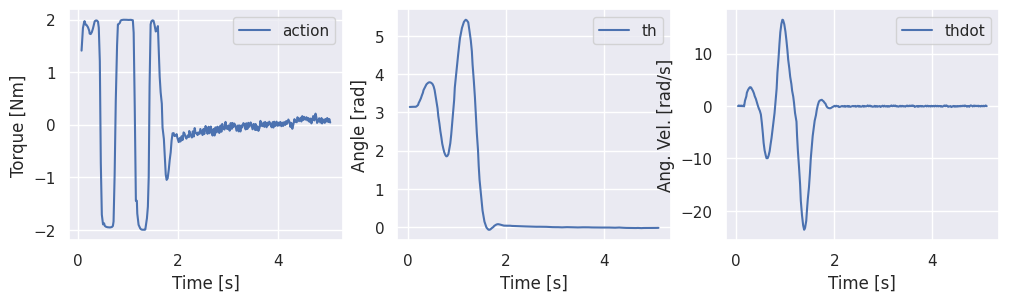

In [21]:
# @title Visualize Actions and Sensor Readings in the Real-World System
# @markdown The following plots display the actions and sensor readings during the evaluation of the policy on the real-world system.

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(eval_record.nodes["agent"].steps.ts_end[:-1], eval_record.nodes["agent"].steps.output.action, label="action")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Torque [Nm]")
axes[0].legend()

axes[1].plot(eval_record.nodes["sensor"].steps.ts_end, eval_record.nodes["sensor"].steps.output.th, label="th")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Angle [rad]")
axes[1].legend()

axes[2].plot(eval_record.nodes["sensor"].steps.ts_end, eval_record.nodes["sensor"].steps.output.thdot, label="thdot")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Ang. Vel. [rad/s]")
axes[2].legend();

In [22]:
# @title Visualize the Rollout
# @markdown The following visualization shows the rollout of the pendulum swing-up task, displaying the system's behavior over time.
# @markdown Note: Html visualization may not work properly if rendering simultaneously in multiple cells.
# @markdown In such cases, comment-out all but one HTML(pendulum.render(rollout)).
from rex.pendulum.render import render
HTML(render(eval_real_rollout, dt=float(1/world.rate)))